# Model Selection for Neural Networks

## Setup

In [1]:
## adapt this directory to your needs
data_dir = 'data/'

In [2]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import tensorflow as tf

from pyMLaux import show_img_data, plot_history, evaluate_classification_result

In [3]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Load Simple Digit Recognition Data

In [4]:
dig_train_raw = pd.read_csv(data_dir + 'Digits_training.csv', sep=',')
dig_train = {'data': np.array(dig_train_raw.iloc[:, :-1]),
             'target': np.array(dig_train_raw.iloc[:, -1]),
             'feature_names': dig_train_raw.columns[:-1],
             'target_names': [str(i) for i in range(0, 10)]}

In [5]:
dig_test_raw = pd.read_csv(data_dir + 'Digits_test.csv', sep=',')
dig_test = {'data': np.array(dig_test_raw.iloc[:, :-1]),
            'target': np.array(dig_test_raw.iloc[:, -1]),
            'feature_names': dig_test_raw.columns[:-1],
            'target_names': [str(i) for i in range(0, 10)]}

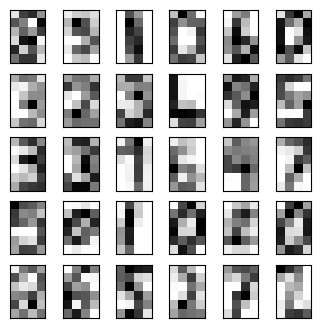

In [6]:
show_img_data(dig_train['data'].reshape((dig_train['data'].shape[0], 6, 4, 1)), figsize=(4, 4),
              interpolation=None)

In [7]:
dig_train['target'][range(0, 30)].reshape(5, 6)

array([[8, 5, 1, 0, 6, 0],
       [3, 2, 3, 4, 9, 5],
       [3, 3, 1, 6, 4, 7],
       [5, 0, 1, 0, 2, 0],
       [2, 6, 5, 2, 7, 2]], dtype=int64)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(dig_train['data'], dig_train['target'],
                                                  test_size=0.3, random_state=4232)

## Functions for Hyperparameter/Architecture Selection

For this method, I decided to pass the options as parameters, so I can change them on the fly for the versions of 100 variations and 50 variations later.
I also decided to enlarge the range of the learning rate because the best models previously often shared the lower bound. I mistakenly also changed the upper bound, but didn't want to execute it again since it would cause different results yet again. I also settled to sort the "Hidden Layer" list, to avoid fluctuating numbers of neurons per layer (avoid going up and down with the count). Finally, sigmoid was removed from the list of activation functions, due to the vanishing gradient problem in deep neural networks. Other changes from the base file include changing some of the vectors slightly.

In [9]:
def create_hyperparams(n, 
                       lr, 
                       epoch_options, 
                       no_layers_options, 
                       hidden_layer_options,
                       dropout_options, 
                       activation_options):
    df = pd.DataFrame(index=range(n),
                      columns=['no_hidden_layers', 'hidden_layers', 'activation', 'dropout', 'lr', 'epochs'])

    for i in range(n):
        df.loc[i, 'lr'] = lr * 5.**random.uniform(-2., 2.)
        df.loc[i, 'epochs'] = random.sample(epoch_options, 1)[0]
    
        no_layers = random.randint(1, 4)
        df.loc[i, 'no_hidden_layers'] = no_layers 
        df.loc[i, 'hidden_layers'] = sorted([int(random.sample(hidden_layer_options, 1)[0]) for i in range(no_layers)], reverse=True)
        df.loc[i, 'dropout'] = random.sample(dropout_options, 1)[0]
        df.loc[i, 'activation'] = random.sample(activation_options, 1)[0]
    
    return(df)

In [10]:
def create_network(hp, no_inputs, no_outputs, output_activation='softmax', **kwargs):
    hidden_layers = hp['hidden_layers']
    
    dropout = hp['dropout']
    hidden_activation = hp['activation']
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(no_inputs, )))

    for cl in hidden_layers:
        model.add(tf.keras.layers.Dense(cl, activation=hidden_activation))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))
            
    model.add(tf.keras.layers.Dense(no_outputs, activation=output_activation)) 

    opt = tf.keras.optimizers.Adam(learning_rate=hp['lr'])

    model.compile(optimizer=opt, **kwargs)

    return(model)

In [11]:
def find_best(df, crit='ACC'):
    index = np.where(df[crit] == np.amax(df[crit]))[0]
    return(df.iloc[list(index), :])

## Perform Model Selection and Determine Best Model

### Set of 100 models

In [12]:
random.seed(4232)
batch_size = 32
no_models = 100

In [13]:
model_sel = create_hyperparams(no_models, 
                               0.001, 
                               [32, 64, 128, 256], 
                               [1, 2, 3, 4], 
                               [64, 256, 512],
                               [0.2, 0.25, 0.3], 
                               ['relu', 'elu'])
model_sel['ACC'] = -1

In [14]:
model_sel

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
0,4,"[512, 64, 64, 64]",relu,0.25,0.000714,128,-1
1,4,"[512, 64, 64, 64]",elu,0.3,0.006199,32,-1
2,4,"[512, 256, 256, 256]",elu,0.3,0.003647,256,-1
3,4,"[512, 256, 256, 64]",elu,0.3,0.016225,32,-1
4,2,"[512, 512]",relu,0.2,0.024626,32,-1
...,...,...,...,...,...,...,...
95,2,"[512, 256]",elu,0.2,0.000108,64,-1
96,3,"[256, 256, 64]",elu,0.3,0.000404,32,-1
97,3,"[512, 64, 64]",relu,0.25,0.000766,256,-1
98,4,"[512, 512, 256, 256]",elu,0.25,0.001503,256,-1


In [15]:
for i in tqdm(range(no_models)):
    model = create_network(model_sel.iloc[i], no_inputs=X_train.shape[1],
                           no_outputs=10, loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])

    history = model.fit(x=X_train, y=y_train, 
                        epochs=model_sel['epochs'][i],
                        batch_size=batch_size, 
                        verbose=0)

    pred = model.predict(x=X_val, verbose=0)
    predC = np.argmax(pred, axis=1)

    model_sel.loc[i, 'ACC'] = accuracy_score(y_val, predC)

    tf.keras.backend.clear_session()

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
model_sel.sort_values(by='ACC', ascending=False).head(10)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
38,4,"[512, 256, 256, 64]",relu,0.25,0.000113,256,0.955556
97,3,"[512, 64, 64]",relu,0.25,0.000766,256,0.955556
75,4,"[512, 512, 256, 64]",relu,0.3,0.000484,64,0.953333
52,1,[512],relu,0.3,0.009536,256,0.953333
80,2,"[512, 64]",relu,0.25,0.000919,256,0.953333
0,4,"[512, 64, 64, 64]",relu,0.25,0.000714,128,0.952222
37,2,"[512, 64]",relu,0.2,0.002918,64,0.952222
6,4,"[512, 512, 256, 64]",relu,0.25,0.000462,64,0.952222
56,3,"[512, 512, 64]",relu,0.2,0.000604,256,0.951111
71,3,"[512, 512, 512]",relu,0.3,0.000148,64,0.950000


In [17]:
find_best(model_sel)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
38,4,"[512, 256, 256, 64]",relu,0.25,0.000113,256,0.955556
97,3,"[512, 64, 64]",relu,0.25,0.000766,256,0.955556


In [18]:
best_index = find_best(model_sel).index[0]

### Narrow down to 50
The best 10 models before, only rarely featured only 1 hidden layer, and only used RELU as an activation function. Also, 32 Epochs were never used. I'd therefor remove these options.

In [19]:
no_models = 50
model_sel = create_hyperparams(no_models, 
                               0.001, 
                               [128, 256], 
                               [2, 3, 4], 
                               [64, 256, 512],
                               [0.2, 0.25, 0.3], 
                               ['relu'])
model_sel['ACC'] = -1

In [20]:
model_sel

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
0,1,[256],relu,0.3,0.000331,256,-1
1,4,"[512, 256, 64, 64]",relu,0.3,0.000416,256,-1
2,2,"[64, 64]",relu,0.25,0.000056,256,-1
3,3,"[256, 256, 64]",relu,0.2,0.000277,128,-1
4,1,[512],relu,0.2,0.00168,256,-1
5,3,"[512, 64, 64]",relu,0.25,0.004181,256,-1
6,2,"[512, 64]",relu,0.25,0.021843,256,-1
7,3,"[512, 256, 256]",relu,0.25,0.000103,256,-1
8,2,"[512, 64]",relu,0.25,0.000719,256,-1
9,1,[64],relu,0.2,0.000696,256,-1


In [21]:
for i in tqdm(range(no_models)):
    model = create_network(model_sel.iloc[i], no_inputs=X_train.shape[1],
                           no_outputs=10, loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])

    history = model.fit(x=X_train, y=y_train, 
                        epochs=model_sel['epochs'][i],
                        batch_size=batch_size, 
                        verbose=0)

    pred = model.predict(x=X_val, verbose=0)
    predC = np.argmax(pred, axis=1)

    model_sel.loc[i, 'ACC'] = accuracy_score(y_val, predC)

    tf.keras.backend.clear_session()

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
model_sel.sort_values(by='ACC', ascending=False).head(10)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
10,4,"[512, 256, 64, 64]",relu,0.25,0.000796,256,0.957778
37,2,"[512, 64]",relu,0.3,0.000441,128,0.956667
8,2,"[512, 64]",relu,0.25,0.000719,256,0.956667
38,1,[512],relu,0.2,0.000781,256,0.956667
1,4,"[512, 256, 64, 64]",relu,0.3,0.000416,256,0.956667
40,3,"[512, 256, 256]",relu,0.3,0.00085,128,0.956667
23,3,"[256, 256, 64]",relu,0.2,0.000205,256,0.955556
4,1,[512],relu,0.2,0.00168,256,0.955556
41,1,[512],relu,0.2,0.001038,256,0.954444
17,4,"[512, 512, 512, 64]",relu,0.25,0.000068,128,0.953333


In [23]:
find_best(model_sel)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
10,4,"[512, 256, 64, 64]",relu,0.25,0.000796,256,0.957778


In [24]:
best_index = find_best(model_sel).index[0]

## Train Model on Entire Training Set Using Best Parameters 


In [25]:
model = create_network(model_sel.loc[best_index], no_inputs=X_train.shape[1],
                       no_outputs=10, loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               12800     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [27]:
history = model.fit(x=dig_train['data'], y=dig_train['target'], 
                    epochs=model_sel.loc[best_index, 'epochs'],
                    batch_size=batch_size)

Epoch 1/256
94/94 [==============================] - 1s 5ms/step - loss: 1.9176 - accuracy: 0.3143
Epoch 2/256
94/94 [==============================] - 0s 3ms/step - loss: 1.0956 - accuracy: 0.6317
Epoch 3/256
94/94 [==============================] - 0s 3ms/step - loss: 0.7650 - accuracy: 0.7573
Epoch 4/256
94/94 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.8027
Epoch 5/256
94/94 [==============================] - 0s 3ms/step - loss: 0.5345 - accuracy: 0.8347
Epoch 6/256
94/94 [==============================] - 0s 3ms/step - loss: 0.4705 - accuracy: 0.8573
Epoch 7/256
94/94 [==============================] - 0s 3ms/step - loss: 0.4153 - accuracy: 0.8717
Epoch 8/256
94/94 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8830
Epoch 9/256
94/94 [==============================] - 0s 3ms/step - loss: 0.3556 - accuracy: 0.8897
Epoch 10/256
94/94 [==============================] - 0s 3ms/step - loss: 0.3362 - accuracy: 0.8993
Epoch 11/

## Test Model on Test Data 

In [28]:
pred = model.predict(dig_test['data'])

evaluate_classification_result(dig_test['target'], pred);

63/63 [==============================] - 0s 2ms/step
[[208   3   0   0   0   0   1   0   0   0]
 [  0 200   1   0   1   0   0   1   0   0]
 [  0   2 183   0   0   0   0   0   0   1]
 [  1   2   1 190   1   4   0   1   0   2]
 [  0   4   0   0 202   0   1   0   0   1]
 [  1   2   0   1   0 179   7   0   0   0]
 [  2   2   0   0   2   2 195   0   1   0]
 [  0   2   1   1   0   0   0 195   1   2]
 [  2   7   0   3   1   1   2   1 173   3]
 [  2  10   2   3   1   3   0   0   0 183]]


Class 0:
    Sensitivity (TPR):  98.113% (208 of 212)
    Specificity (TNR):  99.554% (1784 of 1792)
    Precision:          96.296% (208 of 216)
    Neg. pred. value:   99.776% (1784 of 1788)
Class 1:
    Sensitivity (TPR):  98.522% (200 of 203)
    Specificity (TNR):  98.112% (1767 of 1801)
    Precision:          85.470% (200 of 234)
    Neg. pred. value:   99.831% (1767 of 1770)
Class 2:
    Sensitivity (TPR):  98.387% (183 of 186)
    Specificity (TNR):  99.725% (1813 of 1818)
    Precision:          97.

In [29]:
model.save("Pritz_Sebastian.hdf5")